<font size="8"> **Adding environmental data from ACCESS-OM2-01 to unique crabeater observations** </font>  
In this notebook, we will extract environmental data from the ACCESS-OM2-01 model outputs and add it to our data frame containing unique crabeater sightings per month and grid cell (see `04_Creating_bio_data_masks.ipynb` for more information.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [2]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant libraries

In [3]:
from dask.distributed import Client
from glob import glob
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Paralellising work 

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35019,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:38795,Total threads: 1
Dashboard: /proxy/36665/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43217,


# Loading unique crabeater seal observations data frame

In [16]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Cleaned_Data/unique_crabeater_obs_grid.csv')

#Ensuring date column is formatted correctly (year-month)
crabeaters['date'] = crabeaters.apply(lambda x: f'{x.year}-{str(x.month).zfill(2)}', axis = 1)

#Selecting data for crabeaters during weaning period
crabeaters = crabeaters[crabeaters.life_stage == 'weaning']

#Checking results
crabeaters

,event_date,date,year,month,yt_ocean,xt_ocean,yu_ocean,xu_ocean,season_year,life_stage,decade,sector,zone,presence
445,2011-12-13T00:00:00Z,2011-12,2011,12,-65.184,-64.15,-65.206,-64.1,summer,weaning,2010,East Pacific,Antarctic,1
446,1986-11-19T00:00:00Z,1986-11,1986,11,-62.218,-58.95,-62.195,-59.0,autumn,weaning,1980,East Pacific,Antarctic,1
448,2022-12-13T00:00:00Z,2022-12,2022,12,-66.916,-66.75,-66.895,-66.8,summer,weaning,2020,East Pacific,Antarctic,1
449,2006-11-01T00:00:00Z,2006-11,2006,11,-62.955,-60.55,-62.978,-60.6,autumn,weaning,2000,East Pacific,Antarctic,1
452,2022-12-15T00:00:00Z,2022-12,2022,12,-64.633,-62.55,-64.611,-62.6,summer,weaning,2020,East Pacific,Antarctic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,2005-12-20T04:06:45Z,2005-12,2005,12,-64.718,107.55,-64.739,107.5,summer,weaning,2000,Central Indian,Antarctic,1
3924,2005-12-18T01:37:59Z,2005-12,2005,12,-65.311,108.75,-65.332,108.8,summer,weaning,2000,Central Indian,Antarctic,1
3925,2005-12-18T04:54:03Z,2005-12,2005,12,-65.227,108.55,-65.248,108.6,summer,weaning,2000,Central Indian,Antarctic,1
3926,2005-12-18T05:57:46Z,2005-12,2005,12,-65.227,108.55,-65.206,108.5,summer,weaning,2000,Central Indian,Antarctic,1


In [17]:
print(crabeaters.event_date.min(), crabeaters.event_date.max())

1981-12-27T11:30:00Z 2022-12-15T00:00:00Z


# Loading Indian sectors mask

In [44]:
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))

#Checking result
measo

<xarray.DataArray 'mask' (yt_ocean: 713, xt_ocean: 3600)>
[2566800 values with dtype=float64]
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

## Loading MEASO keys to identify the East and Central Indian sectors

In [43]:
#Loading keys
measo_key = pd.read_csv('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_keys.csv')
#Identifying Indian sectors
measo_key[measo_key.LongName.str.contains('Indian')]

,name,LongName,ID
9,CIA,Central Indian Antarctic,13
10,CIS,Central Indian Subantarctic,14
11,CIN,Central Indian Northern,15
12,EIA,East Indian Antarctic,17
13,EIS,East Indian Subantarctic,18
14,EIN,East Indian Northern,19


## Using codes above to create a new mask for the Indian sectors

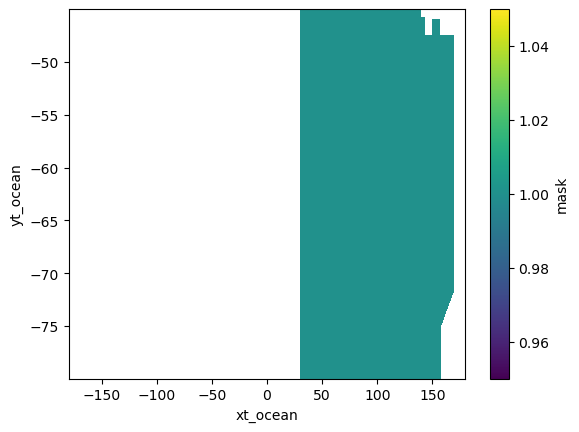

In [45]:
measo_ind = xr.where((measo >= 13) & (measo <= 19), 1, np.nan)
#Checking results
measo_ind.plot()

In [46]:
#Full path to static variables
base_dir_static = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'

#List of static variables
varDict = {'bottom_slope_deg': 'bathy_slope_GEBCO_2D.nc',
           'dist_shelf_km': 'distance_shelf.nc',
           'dist_coast_km': 'distance_coastline.nc',
           'depth_m': 'bathy_GEBCO_2D.nc'}

## Extracting data for each observation and adding it to a new column in crabeater data

In [74]:
#Looping through dictionary keys
for i, var in enumerate(varDict):
    #Creating full path to file of interest
    file_path = os.path.join(base_dir_static, varDict[var])
    #Load as raster
    ras = xr.open_dataarray(file_path)
    #Apply mask
    ras = ras.where(measo_ind == 1, drop = True)
    #Convert to data frame
    ras = ras.to_series().dropna().reset_index()
    #Round coordinate values
    ras = ras.round({'yt_ocean': 3, 'xt_ocean': 3})
    #Renaming masked data before merging to observations
    ras = ras.rename(columns = {ras.columns[-1]: var})
    #Creating data frame with data
    if i == 0:
        static_vars = ras
    else:
        static_vars = static_vars.merge(ras, on = ['yt_ocean', 'xt_ocean'], how = 'left')
    
#Checking results
static_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,135.524276,1.609834,206.816666
1,-71.436,169.65,89.972290,139.029088,10.654348,209.966660
2,-71.436,169.75,89.965401,136.600358,7.133048,273.299957
3,-71.436,169.85,89.950462,134.225430,3.646842,282.933319
4,-71.436,169.95,89.920975,131.907215,0.878910,282.933319
...,...,...,...,...,...,...
573542,-45.107,139.55,89.984383,1922.333851,2082.955257,4595.020996
573543,-45.107,139.65,89.985489,1923.484941,2083.891501,4893.250000
573544,-45.107,139.75,89.967529,1924.656796,2084.846193,4900.333496
573545,-45.107,139.85,89.896507,1925.849377,2085.819306,4900.333496


# Saving results

In [75]:
static_vars.to_csv('../Cleaned_Data/All_values_ACCESS-OM2-01_static_vars.csv', index = False)

## Accessing ACCESS-OM2-01 model outputs
We will create a new `cosima cookbook` session to load the model outputs of interest, and we will also create a dictionary that contains useful information related to data extraction.

In [77]:
#Creating new COSIMA cookbook session
session = cc.database.create_session()

#Creating dictionary with useful information
varDict = {'model': 'ACCESS-OM2-01',
           #ACCESS-OM2-01 cycle 4 (1958-2018)
           'exp': '01deg_jra55v140_iaf_cycle4',
           #ACCESS-OM2-01 cycle 4 extension (2018-2022)
           'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
           #Temporal resolution
           'freq': '1 monthly',
           #Output folder
           'base_out': '../Cleaned_Data'}

## Loading data frame with ACCESS-OM2-01 outputs
We can use this data frame to find the variable names for the environmental factors that we know are influential for the distribution of crabeater seals.

In [79]:
#Loading data frame with model outputs
# var_acc = cc.querying.get_variables(session, experiment = varDict['exp_ext'], frequency = '1 monthly')

#Searching data frame for variables of interest
var_acc[var_acc.long_name.str.contains('free')]

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
57,frzmlt_m,freeze/melt potential,W/m^2,1 monthly,output1008/ice/OUTPUT/iceh.2023-03.nc,time: mean,51,2019-01-01 00:00:00,2023-04-01 00:00:00


## Completing dictionary with useful variables
Now that we identified the correct name for the variable of our interest, we can complete our dictionary.

In [80]:
#Variable name in the model
varDict['var_mod'] = 'frzmlt_m'
#Name of column where we will store the extracted data
varDict['var_short_name'] = 'freez_pot_Wm2'
#Defining if this variable is related to sea ice or not
varDict['ice_data'] = True
#Checking final dictionary
varDict

{'model': 'ACCESS-OM2-01',
 'exp': '01deg_jra55v140_iaf_cycle4',
 'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
 'freq': '1 monthly',
 'base_out': '../Cleaned_Data',
 'var_mod': 'frzmlt_m',
 'var_short_name': 'freez_pot_Wm2',
 'ice_data': True}

## Loading data from ACCESS-OM2-01
The crabeater data has data between 1978 and 2022. The ACCESS-OM2-01 originally had a temporal range of 60 years (1958-2018). However, for the 4th model run (used in these notebooks), the model was extended to December 2022. These outputs are available in two different experiments, which are loaded and merged below before data extraction occurs.

In [83]:
#Loading data from fourth cycle (temporal range 1958 to 2018)
# var_df = uf.getACCESSdata_SO(varDict['var_mod'], '1981-11', '2019-01', 
#                               freq = varDict['freq'], ses = session, minlat = -90,
#                               exp = varDict['exp'], ice_data = varDict['ice_data'])
# #Loading data from fourth cycle extension (2019 to 2022)
# var_df_ext = uf.getACCESSdata_SO(varDict['var_mod'], '2019-01', '2023-01', 
#                               freq = varDict['freq'], ses = session, minlat = -90,
#                               exp = varDict['exp_ext'], ice_data = varDict['ice_data'])

# #Concatenating both data arrays into one
# var_df = xr.concat([var_df, var_df_ext], dim = 'time')

# #Transforming longitudes so their range is +/-180 degrees
# var_df = uf.corrlong(var_df)

#Removing duplicate variable
# del var_df_ext

#Applying Indian sectors mask
var_df = var_df.where(measo_ind == 1, drop = True)
var_df

<xarray.DataArray 'frzmlt_m' (time: 495, yt_ocean: 713, xt_ocean: 1400)>
dask.array<where, shape=(495, 713, 1400), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1981-10-31T12:00:00 ... 2022-12-31T12:00:00
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
Attributes:
    units:          W/m^2
    long_name:      freeze/melt potential
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## *Optional: Data transformation*
Some variables, such as sea surface temperature are in units of Kelvin instead of $^{\circ}C$ (shown below). In this section, we transform variables to the units of our choice.

In [56]:
#Temperature data is transformed from Kelvins to C
var_df = var_df-273.15

## *Optional: Subsetting surface layer data*
For some ocean variables, we need to subset data to extract surface values or bottom values. Subsetting data for the surface layer is an easy process, we simply need to select the first depth bin available. The `st_ocean` dimension contains the depth bins.

In [42]:
#Selecting the first depth available in the model (i.e. surface layer)
var_df = var_df.isel(st_ocean = 0)

#Checking results - dataset has three dimensions instead of the original four
var_df

<xarray.DataArray 'u' (time: 541, yu_ocean: 714, xu_ocean: 3600)>
dask.array<getitem, shape=(541, 714, 3600), dtype=float32, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -45.14 -45.07 -45.0
    st_ocean  float64 0.5413
  * time      (time) datetime64[ns] 1977-12-16T12:00:00 ... 2022-12-16T12:00:00
Attributes: (12/13)
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## *Optional: Subsetting bottom data*
Subsetting data for the bottom layer is not as straightforward as for the surface. This is because the bathymetry is not the same across the Southern Ocean. To identify the correct depth bin that contains the deepest values for a particular grid cell.

In [51]:
mask_2d = xr.where(~np.isnan(var_df.isel(time = 0)), 1, np.nan)
mask_2d = mask_2d.cumsum('st_ocean').where(~np.isnan(var_df.isel(time = 0)))
mask_2d = xr.where(mask_2d == mask_2d.max('st_ocean'), 1, np.nan)
mask_2d

<xarray.DataArray 'u' (st_ocean: 75, yu_ocean: 714, xu_ocean: 3600)>
dask.array<where, shape=(75, 714, 3600), dtype=float64, chunksize=(19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -45.14 -45.07 -45.0
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      datetime64[ns] 1977-12-16T12:00:00

In [52]:
var_2d = (mask_2d*var_df).sum('st_ocean')
var_2d

<xarray.DataArray 'u' (yu_ocean: 714, xu_ocean: 3600, time: 541)>
dask.array<sum-aggregate, shape=(714, 3600, 541), dtype=float64, chunksize=(135, 180, 1), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -45.14 -45.07 -45.0
  * time      (time) datetime64[ns] 1977-12-16T12:00:00 ... 2022-12-16T12:00:00

In [53]:
if var_df.name in ['u', 'v']:
    var_df = var_2d.transpose('time', 'yu_ocean', 'xu_ocean')
else:
    var_df = var_2d.transpose('time', 'yt_ocean', 'xt_ocean')
#Checking results
var_df

<xarray.DataArray 'u' (time: 541, yu_ocean: 714, xu_ocean: 3600)>
dask.array<transpose, shape=(541, 714, 3600), dtype=float64, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -45.14 -45.07 -45.0
  * time      (time) datetime64[ns] 1977-12-16T12:00:00 ... 2022-12-16T12:00:00

## Loading dynamic variables derived from calculations
These variables are not directly available in ACCESS-OM2-01, but they have been calculated from model outputs. Refer to folder `02_Environmental_Data` to see the full details of each calculation.

In [71]:
var_df = xr.open_mfdataset(sorted(glob('/g/data/v45/la6889/Chapter2_Crabeaters/SeaIce/LongTerm_PackIce/*.nc'))).aice_m
var_df

<xarray.DataArray 'aice_m' (time: 540, yt_ocean: 713, xt_ocean: 3600)>
dask.array<concatenate, shape=(540, 713, 3600), dtype=float64, chunksize=(12, 713, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * time      (time) datetime64[ns] 1978-01-01 1978-02-01 ... 2022-12-01

# Calculating mean over time for weaning period
We will include data from 1981 to 2022. The weaning period includes the months of November and December.

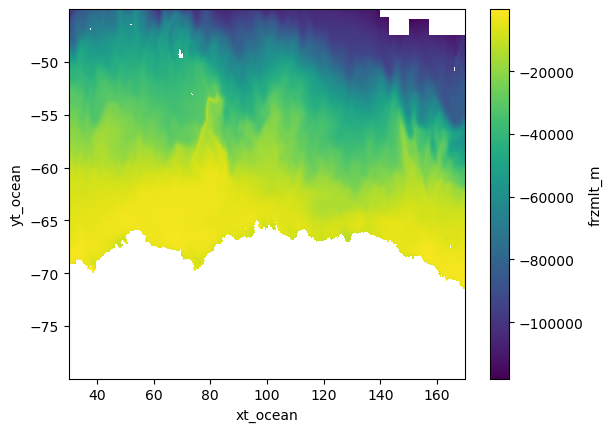

In [91]:
#Identifying timesteps to be included in calculations
mean_var = [da for m, da in var_df.groupby('time.month') if m in [11, 12]]
#Concatenating into single data array and calculate mean over entire time period
mean_var = xr.concat(mean_var, dim = 'time').mean('time')
#Checking results
mean_var.plot()

## Adding mean calculations to static data

In [94]:
env_vars = pd.read_csv('../Cleaned_Data/All_values_ACCESS-OM2-01_static_vars.csv')
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,135.524276,1.609834,206.81667
1,-71.436,169.65,89.972290,139.029088,10.654348,209.96666
2,-71.436,169.75,89.965401,136.600358,7.133048,273.29996
3,-71.436,169.85,89.950462,134.225430,3.646842,282.93332
4,-71.436,169.95,89.920975,131.907215,0.878910,282.93332
...,...,...,...,...,...,...
573542,-45.107,139.55,89.984383,1922.333851,2082.955257,4595.02100
573543,-45.107,139.65,89.985489,1923.484941,2083.891501,4893.25000
573544,-45.107,139.75,89.967529,1924.656796,2084.846193,4900.33350
573545,-45.107,139.85,89.896507,1925.849377,2085.819306,4900.33350


In [92]:
#Converting to pandas data frame
var_pd = mean_var.to_series().dropna().reset_index()
#Round coordinate values
var_pd = var_pd.round({'yt_ocean': 3, 'xt_ocean': 3})
#Renaming masked data before merging to observations
var_pd = var_pd.rename(columns = {varDict['var_mod']: varDict['var_short_name']})
#Checking results
var_pd.head()

,yt_ocean,xt_ocean,freez_pot_Wm2
0,-71.563,169.95,-3772.421387
1,-71.520,169.85,-4044.137695
2,-71.520,169.95,-4209.175781
3,-71.478,169.55,-3916.464355
4,-71.478,169.65,-4048.792725


## Merging all variables together

In [95]:
#Merging columns
env_vars = env_vars.merge(var_pd, on = ['yt_ocean', 'xt_ocean'], how = 'left')
env_vars

## Saving results

In [ ]:
env_vars.to_csv('../Cleaned_Data/All_values_ACCESS-OM2-01_env_vars.csv', index = False)